# Passing Extra Parameters in Python

This notebook is intended to develop ancillary skills in Python, specifically passing extra parameters to equation solvers. The Notebooks to this point have covered basic root finding with univariate solvers in Python. We can handle considerably more complex problems in a much more efficient way if we can learn to pass parameters instead of hard coding parameters within the scope of a single problem solution. To cover this topic, we will revist ammonia synthesis at varying temperatures and pressures, which was covered in [Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html). We have already solved this problem, and now that we know the answer and have some expectations about the system, we will now use it as a platform to learn about passing extra parameters to equation solvers like `opt.newton()` or `opt.root()`. This notebook has some light review of equilibrium concepts, but it is primarily a Python exercise.

In [40]:
import numpy as np
import scipy.optimize as opt 
import matplotlib.pyplot as plt

## Ammonia Synthesis Under Industrial Conditions

In [Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html), we discussed the importance of temperature in determining the equilibrium position for ammonia synthesis:

$$N_2 (g) + 3H_2 (g) \leftrightharpoons 2N\!H_3 (g)$$

This reaction is ***exothermic*** and leads to a substantial ***loss of entropy***. This means that it is (very) enthalpically favorable and (very) entropically unfavorable, and it will be very sensitive to changes in temperature.  We found that it is extremely favorable at room temperature ($X_{N_2} \approx 0.97$ at $T = 298$K); unfortunately, the kinetics of this reaction are too slow at 298K for it to be industrially feasible. To achieve a workable reaction rate, we might have to run at something like $T = 873$K; unfortunately, we found that ammonia synthesis is very thermodynamically unfavorable at this temperature ($X_{N_2} \approx 8.0 \times 10^{-4}$ at $T = 873$K). This prompted us to increase pressure, but we found that we would need to operate at nearly 1000 bar to allow workable nitrogen conversions at equilibrium ($X_{N_2} \approx 0.38$ at $T = 873$K and $P = 1000$bar).  Materials and operating cost prevent us from running ammonia synthesis at 1000 bar at full scale, so it is essential to decrease temperature in order to get a more favorable equilibrium position; however, this must be done without reducing the reaction rate. This is where the introduction of a catalyst is critical -- the Haber-Bosch process relies on a catalyst to achieve high reaction rates at moderate temperatures where the equilibrium position is still unfavorable, but not so unfavorable that we cannot work around it by increasing pressure to 100 - 200 bar ($X_{N_2} \approx 0.51$ at $T = 673$K and $P = 200$ bar).  These pressures are high and expensive, but they are industrially feasible.

Below, we recap the solution already presented in [Notebook 08](https://jqbond.github.io/CEN587/Notebooks/587-N08.html).

## Example Problem 01

What is the equilibrium conversion of $N_2$ during ammonia synthesis at 873K, 1 bar, and starting with a 3:1 ratio of $H_2$:$N_2$? 

### Solution to Example Problem 01

We start by recalling the equation below, which relates the standard state change in Gibbs free energy (i.e., ***reaction thermodynamics***) to the equilibrium composition of the reacting system.

$$\exp\left(\frac{-\Delta G^\circ}{RT}\right) = K = \prod_{j = 1}^{N_S}a_j^{\nu_j}$$

#### Thermodynamic data and K

We will start with the left side of the equation. Assuming that we can solve it, it allows us to calculate a numerical value of the equilibrium constant from thermodynamic data. 

$$K = \exp\left(\frac{-\Delta G^\circ}{RT}\right)$$

To find $K$, we have to calculate the standard state Gibbs Free Energy of reaction, $\Delta G^\circ$.  For gas phase reactions like this one, the standard state is pure species at 1 bar and the reaction temperature.  For this example problem, we've ***increased*** the reaction temperature to 873K, so we need to calculate the Gibbs free energy change at 1 bar and 873K. Previously, we only had data at 298K, but we can correct for temperature effects using heat capacities.  They are included for each species in the table below.

|Species      | ${H_j}^\circ (\mathrm{kJ \ mol^{-1}})$| ${S_j}^\circ (\mathrm{J \ mol^{-1} \ K^{-1}})$ | ${C_{p_j}}^\circ (\mathrm{J \ mol^{-1} \ K^{-1}})$|
|-------------|:-------------------------------------:|:----------------------------------------------:|:-------------------------------------------------:|
| $N_2$ (g)   | 0                                     |191.60                                          |29.12                                              | 
| $H_2$ (g)   | 0                                     |130.68                                          |28.84                                              | 
| $N\!H_3$ (g)| -45.9                                 |192.77                                          |35.64                                              |

Now, we can us the data at $T_0 = 298K$ and the various heat capacities to calculate the enthalpy of each species at 873K using the following equation:

$$H_j = H_{j,0} + \int_{T_0}^{T} C_{p_j} dT$$

For heat capacities that are not a function of temperature (here, we have constant heat capacities), we can solve the integral and the equation simplifies to:

$$H_j = H_{j,0} + C_{p_j}(T - T_0)$$

Similarly, we can calculate entropies at a temperature other than $T_0 = 298K$ using the following equation:

$$S_j = S_{j,0} + \int_{T_0}^{T} \frac{C_{p_j}}{T} dT$$

For constant heat capacities like we have in this problem, we can again solve the integral giving:

$$S_j = S_{j,0} + C_{p_j}\ln\left(\frac{T}{T_0}\right)$$

In the cell below, we build a function to calculate enthalpies and entropies at 873K based on our data at 298K and the heat capacities we have available. Just to keep the notation simple, I'll use $N$ = $N_2$, $H = H_2$, and $A$ = $N\!H_3$. Within this function, we also calculate the Gibbs Free Energy of Reaction and the Equilibrium Constant at 873K. The function is pretty simple, and it returns only the equilibrium constant at a specified temperature argument.

In [41]:
#############################################################################
# Creating a versatile function that calculates K at any T, i.e., K(T)      #
#############################################################################

def K(T):
    T0 = 298   #K
    R  = 8.314 #J/mol/K
    
    #Enthalpies at 298K, 1 bar
    HN0 = 0
    HH0 = 0
    HA0 = -45.9*1000 #J/mol

    #Entropies at 298K, 1 bar
    SN0 = 191.60 #J/mol/K
    SH0 = 130.68 #J/mol/K
    SA0 = 192.77 #J/mol/K

    #Heat capacities
    CPN = 29.12 #J/mol/K
    CPH = 28.84 #J/mol/K
    CPA = 35.64 #J/mol/K

    #Calculate thermodynamic state functions at T not equal to T0 = 298
    HN = HN0 + CPN*(T - T0) #J/mol
    HH = HH0 + CPH*(T - T0) #J/mol
    HA = HA0 + CPA*(T - T0) #J/mol

    SN = SN0 + CPN*np.log(T/T0) #J/mol/K
    SH = SH0 + CPH*np.log(T/T0) #J/mol/K
    SA = SA0 + CPA*np.log(T/T0) #J/mol/K

    ΔH = 2*HA - HN - 3*HH #J/mol
    ΔS = 2*SA - SN - 3*SH #J/mol/K
    ΔG = ΔH - T*ΔS        #J/mol

    K  = np.exp(-ΔG/R/T)     #Dimensionless
    return K

T1 = 298 #K
print(f'At T = {T1:0.0f}K, the thermodynamic equilibrium constant for ammonia synthesis is K = {K(T1):0.2E}')

At T = 298K, the thermodynamic equilibrium constant for ammonia synthesis is K = 5.54E+05


#### K is also a function of thermodynamic activities!

Now that we have the equilibrium constant at 873K, 1 bar, and for pure gas reference states, we can address the composition dependence by considering:

$$K = \prod_{j = 1}^{N_S}a_j^{\nu_j}$$

Next, we need to work through the right hand side of that expression and resolve the composition dependencies within the thermodynamic activities. We can apply this equation to the specific example of ammonia synthesis to find:

$$K = \frac{{a_{N\!H_3}}^{2}}{{a_{N_2}}{a_{H_2}}^3}$$

We recall our definitions for thermodynamic activities of gases in a mixture:

$$a_j = \frac{\hat{f}_j}{f_j^\circ}$$

The numerator is the fugacity of species $j$ under reaction conditions ($T = 873K$, $P = 1 \mathrm{bar}$, $x_j = ?$). The denominator is the fugacity of species $j$ in its reference state. Our reference state for gas-phase species is a pure species at 1 bar and the reaction temperature ($T = 873K$). Our convention for calculating fugacities of gases in a mixture uses the Lewis Randall rule. With these things in mind, formally, we have:

$$a_j = \frac{y_j \phi_j P}{y_j^\circ \phi_j^\circ  P^\circ}$$

Looking at the numerator, we are operating this reactor at 1 bar, so the fugacity coefficient for species j under reaction conditions, $\phi_j$, is 1. Looking at the denominator, the reference state is a pure species, so $y_j^\circ = 1$.  Further, that pure species is at 1 bar, so $\phi_j^\circ = 1$. This gives the usual result for low pressure gases:

$$a_j = \frac{y_j P}{P^\circ}$$

Now we apply this equation to all of the species participating in the reaction.  Notice that I'm still retaining $P$ and $P^\circ$ in my solution:

$$K = \frac{\left(\frac{y_{N\!H_3}P}{P^\circ}\right)^2}{\left(\frac{y_{N_2}P}{P^\circ}\right) \left(\frac{y_{H_2}P}{P^\circ}\right)^3}$$

We see multiple pressures and reference pressures that will cancel, giving:

$$K = \frac{{y_{N\!H_3}}^2}{y_{N_2}{y_{H_2}}^3} \left(\frac{P^\circ}{P}\right)^2$$

Now we're at a point that we can't really go any further because we have 3 unknowns ($y_{N\!H_3}$, $y_{N_2}$, and $y_{H_2}$) and only 1 equation.  As before, we address this by solving for the molar quantity of each species using an extent of reaction, stoichiometric coefficients, and the starting quantity of each species.

#### Expressing Mole Fractions as functions of Extent

In general, the mole fraction for a species in the gas phase is defined as:

$$y_j = \frac{N_j}{N_{\textrm{total}}} = \frac{N_j}{\sum_j N_j}$$

We also remember that we can express the moles of each species at any point in the reaction, $N_j$ in terms of the extent of reaction(s) that are occuring in that system.  

$$N_j = N_{j,0} + \nu_j \varepsilon$$

We want to apply this equation for all species in the reactor. We can also see that the total number of moles shows up in the definition of a mole fraction, so we need to track that quantity as well. It is usually a good idea to organize all of this information in a mole table -- no matter how many equilibrium problems I solve, I still always use this simple tool to organize information. We will again relabel the compounds using N ($N_2$), H ($H_2$), and A ($NH_3$).

$$N (g) + 3H (g) \leftrightharpoons 2A (g)$$

|Species   |In        |Change           |End                     |
|:---------|:--------:|:---------------:|:----------------------:|
| $N_2$   |$N_{N0}$  |$-1\varepsilon$  |$N_{N0} - 1\varepsilon$ | 
| $H_2$   |$N_{H0}$  |$-3\varepsilon$  |$N_{H0} - 3\varepsilon$ |
| $N\!H_3$   |$N_{A0}$  |$+2\varepsilon$  |$N_{A0} + 2\varepsilon$ |
| Total    |$N_{T0}$  |$-2\varepsilon$  |$N_{T0} - 2\varepsilon$ |


We can make these substitutions into the definitions of mole fractions, ultimately finding:

$$K = \frac{\left(N_{A,0} + 2\varepsilon\right)^2 \left(N_{T,0} - 2\varepsilon\right)^2}{\left(N_{N,0} - 1\varepsilon\right) \left(N_{H,0} - 3\varepsilon\right)^3} \left(\frac{P^\circ}{P}\right)^2$$

As covered previously, when writing a script to solve a problem, it is often preferable to write the equations in code and allow the script to perform the substitutions rather than doing them by hand and (1) risk making mistakes and (2) generate an objective function that has lost most connections with physically meaningful expressions and definitions.  We build this objective function below.

In [42]:
####################################################################################################################################
# Define the basis; as done here, these are global variables stored in the workspace and accessible within all functions and loops #
####################################################################################################################################

NN0 = 1 #mole of Nitrogen at start
NH0 = 3 #moles of Hydrogen at start
NA0 = 0 #moles of Ammonia at start
NT0 = NN0 + NH0 + NA0 #total moles at start

# Define reference pressure; it is constant throughout all problems
P0  = 1 #bar

In [43]:
def obj1(ε):

    #Specifications for this problem
    T   = 873 #K
    P   = 1.0 #bar
       
    NN  = NN0 - ε
    NH  = NH0 - 3*ε
    NA  = NA0 + 2*ε
    NT  = NN + NH + NA
    
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
    
    aN  = yN*P/P0
    aH  = yH*P/P0
    aA  = yA*P/P0
    
    KCOMP = aA**2/aN/aH**3
    KTHERMO = K(T)       

    return KCOMP - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

# T = 673 #K
# P = 200 #bar
ans, info = opt.newton(obj1, 0.99, full_output = True) #This solves for the equilibrium extent

print(info, '\n') #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'The equilibrium conversion of N2 is {XN:0.2E}, yN is {yN:0.3f}, yH is {yH:0.3f}, and yA is {yA:0.2E}')
# print(f'At T = {T:0.0f}K and P = {P:0.1f}bar, the equilibrium conversion of N2 is {XN:0.2E}, yN is {yN:0.3f}, yH is {yH:0.3f}, and yA is {yA:0.2E}')

      converged: True
           flag: converged
 function_calls: 49
     iterations: 48
           root: 0.0007985377076979054
         method: secant 

The equilibrium conversion of N2 is 7.99E-04, yN is 0.250, yH is 0.750, and yA is 3.99E-04


## Passing T and P as extra arguments to `opt.newton()` or `opt.root()`

Wouldn't it be nice if we could pass T and P as arguments to the objective function? That way, we wouldn't have to hard code their values for every different scenario or store them as global variables in the workspace, which can lead to mistakes when we define global variables multiple times within the same script. We can actually do this easily in Python using either the `args` keyword or using `lambda` functions.  We will cover both ways because they are both useful and either might be "better" depending on the problem you're trying to solve.

To start, we'll write a more general function that contains our system of equations we're trying to solve.  It is almost identical to the form we usually use for `opt.newton()`, but in this case, we relax the requirement that that function only takes one argument (e.g., "ex"), and we give it 3 arguments instead:  `(ex, T, P)`. 

```{warning}
The function below cannot be solved directly with `opt.newton()` because its default configuration only allows functions that accept a single argument.
```

In [44]:
def tempfun2(ε, T, P):

    #Specifications for this problem
    #Trxn = T -- we are passing this into the function as an argument.
    #Prxn = P -- we are passing this into the function as an argument

    # P0  = 1.0 #bar #These are constant parameters that are defined globally in workspace
    # NN0 = 1.0 #moles
    # NH0 = 3.0 #moles
    # NA0 = 0.0 #moles
    
    #Mole Table, this captures extent of reaction
    NN  = NN0 - ε
    NH  = NH0 - 3*ε
    NA  = NA0 + 2*ε
    NT  = NN + NH + NA
    
    #Mole fractions -- note extent is built into definitions of NA, NB, NC, NT
    yN  = NN/NT
    yH  = NH/NT
    yA  = NA/NT
       
    #Activity definitions -- extents embedded in yA, yB, yC; P and P0 also show up.
    aN  = yN*P/P0
    aH  = yH*P/P0
    aA  = yA*P/P0
    
    #This is our ratio of thermodynamic activities at equiliribum, i.e., Kactivity = Product(a_j^nu_j)
    KACTIVITY = aA**2/aN/aH**3
    
    #Calculate the equilibrium constant at T = Trxn
    KTHERMO = K(T) 
       
    return KACTIVITY - KTHERMO  #We want to find the value of extent where KCOMP - Kthermo = 0

In [45]:
print(obj1(0.5))
# print(tempfun2(0.5))
print(tempfun2(0.5, 873, 1))
# opt.newton(tempfun2, 0.01)

5.333331818210124
5.333331818210124


### Passing extra parameters with lambda functions

We can now solve this for any T and P pair by passing them as arguments to the objective function. This is a little more difficult to do than the original example because `opt.newton()` still only takes a single argument ($\varepsilon$).  We can get around this in two ways.  The first we'll illustrate is to use an anonymous or `lambda` function to "pass extra parameters."  This is a standard tool for doing this in most programming languages, and it is the best practice for this style of solution in Matlab and Julia.

In [57]:
Trxn = 873#673 #K
Prxn = 1#200 #bar
obj2 = lambda ε: tempfun2(ε, Trxn, Prxn) #Essentially converts tempfun(ex, T, P) to objective(ex)
print(obj1(0.5))
# print(tempfun2(0.5))
print(obj2(0.5))

5.333331818210124
5.333331818210124


In [60]:
Trxn = 673 #K
Prxn = 200 #bar
obj2 = lambda ε: tempfun2(ε, Trxn, Prxn)
ans, info = opt.newton(obj2, 0.99, full_output = True) #This solves for the equilibrium extent

print(info.flag) #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'At T = {Trxn:0.0f}K and P = {Prxn:0.0f} bar, conversion of N2 is {XN:0.3f}, yN is {yN:0.3f}, yH is {yH:0.3f}, and yA is {yA:0.3f}.')

converged
At T = 673K and P = 200 bar, conversion of N2 is 0.512, yN is 0.164, yH is 0.492, and yA is 0.344.


### Passing extra parameters with the args keyword in Python

The second way to handle this is somewhat specific to Python, but it is convenient and worth knowing.  Both `opt.root()` and `opt.newton()` will accept a keyword argument called `args`.  We can use this to pass extra parameters into equations being solved by numerical methods.  It is functionally identical to what we did above with a lambda function, but the syntax is arguably a little cleaner.

In [61]:
Trxn = 673 #K
Prxn  = 200 #bar
ans, info = opt.newton(tempfun2, 0.98, args = (Trxn, Prxn), full_output = True) #This solves for the equilibrium extent

print(info.flag) #Let's make sure it converged...

#Solve for conversion and mole fractions.
NN = NN0 - ans
NH = NH0 - 3*ans
NA = NA0 + 2*ans
NT = NN + NH + NA
XN = (NN0 - NN)/NN0
yN = NN/NT
yH = NH/NT
yA = NA/NT

print(f'At T = {Trxn:0.0f}K and P = {Prxn:0.0f} bar, conversion of N2 is {XN:0.3f}, yN is {yN:0.3f}, yH is {yH:0.3f}, and yA is {yA:0.3f}.')

converged
At T = 673K and P = 200 bar, conversion of N2 is 0.512, yN is 0.164, yH is 0.492, and yA is 0.344.


## Why go through the trouble?

We have a good reason to set up problems in a more general way like this.  At a minimum, it is clear that this format is nice for allowing us to explore the impact of changing parameters. We don't have to write much extra code, we just pass new values of $(T, P)$ to our objective function and obtain a new solution. This is a nice first step in obtaining very general information about how a reaction will respond to changes in operating conditions.  We shouldn't restrict ourselves to solving the problem at a single $(T, P)$ -- it is much more informative if we can solve the problem at many different temperatures or pressures so that we can develop a good understanding of system behavior and also be able to quantitatively state how the system will respond to a change in operating conditions.

This is a good place to employ loops, which are nice tools for repeating the same operation over a set.  You could imagine writing a loop to, for example, solve the ammonia equilibrium problem at many different temperatures.  We'll do this below. First, let's look a little at how loops behave and how we will work with them. For these examples, we want to run iterations on a known set of temperatures, so a `for` loop is the best tool. In contrast, you want to use a `while` loop if you want to continue an operation until a threshold criterion is met.

In [75]:
####################################################
# Some simple for loop examples                    #
####################################################

letters = ['a', 'b', 'c', 'd', 'e']
numbers = [1, 2, 3, 4, 5]

for entry in letters:
    print(entry)

print()

for value in numbers:
    print(value)

a
b
c
d
e

1
2
3
4
5


In [76]:
for i in range(0, 3):
    print(numbers[i], letters[i+1])

1 b
2 c
3 d


In [77]:
for value in numbers:
    result = value**2
    print(result)

1
4
9
16
25


In [78]:
for i in range(0, len(letters), 1): #this is equivalent to for i in range(0, 5, 1):
    print(i, letters[i])

0 a
1 b
2 c
3 d
4 e


```{caution}
Loops will generally overwrite variables defined within a loop. If you need to store the results generated in the course of a loop, you have to deliberately build this into the loop. There are multiple ways to do this -- you can append the result to an existing array, or you can store the result in pre-allocated space within an array.
```

In [83]:
for k in range(0, len(numbers), 1):
    result_local = numbers[k]**2
    print(k, result_local)

0 1
1 4
2 9
3 16
4 25


In [85]:
result_global = np.zeros(len(numbers))
print(result_global)
for k in range(0, len(numbers), 1):
    result_local = numbers[k]**2
    print(k, result_local)
    result_global[k] = result_local
print('\n', result_local)
print(result_global)

[0. 0. 0. 0. 0.]
0 1
1 4
2 9
3 16
4 25

 25
[ 1.  4.  9. 16. 25.]


The Cell below uses a for loop to solve for the equilibrium conversion during ammonia synthesis at 1 bar and temperatures ranging from 300K to 900K. There is one small change from prior scripts -- it is hard to provide a good initial guess over such a large temperature range, so this script changes the numerical method used by opt.newton() from a secant method (default) to Brent's Method, which does not require an initial guess and offers better stability.

In [92]:
PRXN = 1   #bar
# TSET = [298]
# TSET = [298, 323, 523]
TSET = np.linspace(300, 900, 100) #K

XOUT = np.zeros(len(TSET))
flag = np.zeros(len(TSET))
# print(XOUT)

for j in range(0, len(TSET), 1):
    # print(TSET[j])
    objective = lambda ε: tempfun2(ε, TSET[j], PRXN)
    # ans, info = opt.newton(objective, 0.99, full_output = True)
    ans, info = opt.brentq(objective, 1e-6, 0.99999, xtol = 1e-8, rtol = 1e-8, full_output = True)
    # print(ans, info.converged, '\n')
    XOUT[j] = ans/NN0
    flag[j] = info.converged
    if info.converged == True:
        XOUT[j] = ans/NN0
    if info.converged == False:
        print(info)

print(ans)
print(XOUT)
print(flag)

0.0006260199122987484
[9.65812469e-01 9.58972221e-01 9.51091063e-01 9.42064604e-01
 9.31785653e-01 9.20145549e-01 9.07035854e-01 8.92350607e-01
 8.75989066e-01 8.57859186e-01 8.37881790e-01 8.15995542e-01
 7.92162576e-01 7.66374787e-01 7.38660363e-01 7.09090216e-01
 6.77783604e-01 6.44912287e-01 6.10702164e-01 5.75431706e-01
 5.39426427e-01 5.03049176e-01 4.66686512e-01 4.30732100e-01
 3.95568580e-01 3.61549823e-01 3.28985381e-01 2.98128766e-01
 2.69170488e-01 2.42236127e-01 2.17388945e-01 1.94636166e-01
 1.73937579e-01 1.55215357e-01 1.38363942e-01 1.23259227e-01
 1.09766552e-01 9.77472301e-02 8.70636342e-02 7.75828821e-02
 6.91793690e-02 6.17363111e-02 5.51465409e-02 4.93127378e-02
 4.41472485e-02 3.95716717e-02 3.55162301e-02 3.19190990e-02
 2.87256593e-02 2.58877945e-02 2.33631875e-02 2.11146732e-02
 1.91096335e-02 1.73194698e-02 1.57190987e-02 1.42865243e-02
 1.30024575e-02 1.18499633e-02 1.08141760e-02 9.88203141e-03
 9.04203976e-03 8.28408720e-03 7.59925851e-03 6.97969486e-03
 6

Since we have such a large number of equilibrium solutions, it is much easier to interpret the results if we can visualize them. Below, we graph the equilibrium conversion of nitrogen at 1 bar as a function of temperature from 300K to 900K. It is important to understand that we obtained each data point on this figure by solving an equilibrium problem at a specific reaction temperature. This was accomplished using a for loop.

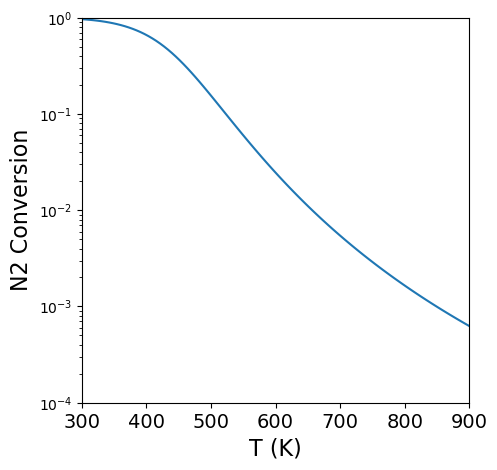

In [93]:
plt.figure(figsize = (5,5))
plt.plot(TSET, XOUT)
plt.yscale('log')
plt.ylabel('N2 Conversion', fontsize = 16)
plt.ylim(10**-4, 1)
plt.xlabel('T (K)', fontsize = 16)
plt.xlim(300, 900)
plt.xticks(np.arange(300, 901, 100), fontsize = 14)
plt.show()